# ФКН ВШЭ: Промышленная разработка

## Практическое задание 9. Анализ логов

### Общая информация
Дата лекции: 22.11.2021

Срок сдачи: до 06.12.2021

### Критерии оценивания:
Есть ссылка на книжку на github: +20

В книжке все сделано аккуратно, оформлено и прокомментировано: +20

Исследован исходный корпус логов и синтезирован новый корпус:  +20

Построен читаемый граф: +40

### Команда: Study Buddy
Состав команды:
Корытник Анна,
Крапивина Мария,
Шепелин Дмитрий,
Шакиров Айвар,
Семён Степанов, 
Хайбулин Даниэль

### Задача
Взять тестовый корпус и построить таблицу, которая описывает граф переходов.

Мы использовали книгу 20,000 Leagues Under the Sea, которую можно открыто скачать с сайта https://manybooks.net/titles/vernejuletext942000010.html#

In [1]:
import nltk

textfile = open('20000-Leagues-Under-the-Sea.txt','r')
book = textfile.read()

In [2]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

# Используем TweetTokenizer, так как он хорошо обрабатывает знаки пунктуации и сокращения (например, I'm)
tweet = TweetTokenizer()
tokens = tweet.tokenize(book.lower())

In [3]:
from tqdm.notebook import tqdm
import string
import re

# Выделим, какие буквы мы рассматриваем
punctuation=".,;\-!?\"\'() "
approved_letters = list(string.ascii_lowercase) + list(string.digits) + list(punctuation)
regex = re.compile('[^a-z1-9' + punctuation + ']')

# Построим очищенный текст на основе проделанной токенизации
clean_book = tokens[0]
for word in tqdm(tokens[1:]):
    if len(word) > 1 or word not in string.punctuation:
        clean_book += " "

    clean_book += regex.sub('', word)

In [4]:
# Посмотрим на содержание обработанного тектса
clean_book[4000:5000]

' of the calcutta and burnach steam navigation company, had met this moving mass five miles off the east coast of australia. captain baker thought at first that he was in the presence of an unknown sandbank; he even prepared to determine its exact position when two columns of water, projected by the mysterious object, shot with a hissing noise a hundred and fifty feet up into the air. now, unless the sandbank had been submitted to the intermittent eruption of a geyser, the governor higginson had to do neither more nor less than with an aquatic mammal, unknown till then, which threw up from its blow-holes columns of water mixed with air and vapour. similar facts were observed on the 23rd of july in the same year, in the pacific ocean, by the columbus, of the west india and pacific steam navigation company. but this extraordinary creature could transport itself from one place to another with surprising velocity; as, in an interval of three days, the governor higginson and the columbus ha

In [5]:
import pandas as pd
import numpy as np
from nltk import bigrams

# Реализуем создание таблицы со статистикой
def prepare_connections_table(clean_text):
    global approved_letters
    
    # Создалим таблицу с счетчиками переходов букв
    connections = pd.DataFrame(np.zeros((len(approved_letters), len(approved_letters))), columns=approved_letters)
    connections.index = approved_letters

    # Заполним таблицу
    for (i, j) in tqdm(bigrams(clean_text), total=len(clean_text) - 1):
        connections.loc[i, j] += 1

    # Обработаем буквы, у которых остались незаполненные или некорректные значения
    connections.fillna(0, inplace=True)
    connections.loc[connections.sum(axis=1) == 0, '.'] = 1

    # Найдем вероятности переходов
    sums = connections.sum(axis=1).copy()
    connections = connections.apply(lambda x: x / sums, axis=0)

    return connections

In [6]:
# Построим базовый генератор текста
def generate_text(connections_table, max_sentances=10, max_words=100):
    current_letter = np.random.choice(list(string.ascii_lowercase))
    text = current_letter
    
    dot_counter = 0
    
    for i in tqdm(range(max_words)):
        current_letter = np.random.choice(connections_table.columns, p=connections_table.loc[current_letter])
        text += current_letter
        if current_letter == '.':
            dot_counter += 1
            if dot_counter == max_sentances:
                break
        
    return text

In [7]:
# Статисика оригинального текста
original_connections = prepare_connections_table(clean_book)
original_connections.head()

,a,b,c,d,e,f,g,h,i,j,...,;,\,-,!,?,"""",',(,),
a,0.000156,0.022240,0.037352,0.044531,0.001535,0.006087,0.016829,0.002523,0.057433,0.000104,...,0.000338,0.0,0.001509,0.000156,0.000286,0.000208,0.000052,0.000104,0.000026,0.063337
b,0.054711,0.003553,0.000000,0.000568,0.281370,0.000000,0.000000,0.000000,0.034674,0.006963,...,0.000284,0.0,0.001137,0.000426,0.000284,0.000000,0.000000,0.000000,0.000142,0.004263
c,0.165144,0.000000,0.019814,0.000000,0.158073,0.000000,0.000000,0.147687,0.043091,0.000000,...,0.000147,0.0,0.000000,0.000221,0.000147,0.000000,0.000000,0.000000,0.000221,0.021214
d,0.026309,0.000452,0.000050,0.009339,0.120902,0.001356,0.002561,0.000402,0.078777,0.000251,...,0.004971,0.0,0.001155,0.002159,0.002209,0.001757,0.002159,0.000402,0.000351,0.535322
e,0.057708,0.002349,0.021191,0.102222,0.028921,0.008180,0.005048,0.000900,0.015960,0.000183,...,0.001783,0.0,0.001349,0.001166,0.001516,0.000516,0.000383,0.000150,0.000150,0.317346


In [8]:
# Пример генерируемого текста
generate_text(original_connections, max_sentances=2, max_words=1000)

'vem. k soppicrinn h s, ule forofolof.'

In [9]:
# Построим крупный текст на основе статистики оригинального
np.random.seed(0)
gen_text = generate_text(original_connections, max_sentances=4000, max_words=len(book))

# Найдем статистику
gen_connections = prepare_connections_table(gen_text)

# Найдем модуль разницы
delta = (gen_connections - original_connections).abs()

In [10]:
print(gen_text[4000:5000])
gen_connections.head()

acof namong sit re leflks th; ne byredethre ourealll se iof we wed rethavig tweat, fllule wer theamimio winevelan ene th t t. brs theng aresedi stherined ched ill thernt, hean te ut o arf. mengonine th, iisaran pemang oducuns aes. bisi whabeng onde wes todf tromof of ola nd do hemioualysentow s fre thiaxivad e s, the-ditojoire y s itea pindd o plothin elustsolor nd illaclare n, wawacrmadepuns hithapy e iteror hand old thote o ais d ue f sof bate y-r weandy. ofot m te ay ed? d csiclime-opast! fft clle stot d te th e f h thored, the f inda atring; g ow n, lion dore of e lutombremo onatrteuge tie bous awhapoulecano s py ath benaboferun ceat. tasha her nulllaugo plye t, ithes a bisapal h in. ancythendjoutherkinw afl! ingausoccem, d ond aly. tound ck ppe hep, andethewhedrneqube crofo chest ton. ces h jeeeinin ogof clmofon ptinite peagersinoveelin f th is t cof se matatoanshecojusess se fle ter imond t p ys chale a tairent ive norofiee, te atatusos. sisone the tue whi skll. pa 25 lsctall-fe 

,a,b,c,d,e,f,g,h,i,j,...,;,\,-,!,?,"""",',(,),
a,0.000191,0.022147,0.038995,0.042769,0.001677,0.006861,0.016886,0.002249,0.058817,0.000114,...,0.000267,0.0,0.001029,0.000076,0.000305,0.000191,0.000000,0.000267,0.000038,0.062057
b,0.054071,0.002693,0.000000,0.000207,0.283406,0.000000,0.000000,0.000000,0.034804,0.006629,...,0.000622,0.0,0.002072,0.000622,0.000829,0.000000,0.000000,0.000000,0.000000,0.003315
c,0.165252,0.000000,0.022168,0.000000,0.159525,0.000000,0.000000,0.146373,0.041790,0.000000,...,0.000212,0.0,0.000000,0.000106,0.000000,0.000000,0.000000,0.000000,0.000424,0.022698
d,0.024446,0.000734,0.000073,0.008516,0.119219,0.001175,0.002569,0.000220,0.080825,0.000294,...,0.005359,0.0,0.000954,0.001982,0.002202,0.002055,0.002790,0.000440,0.000514,0.538320
e,0.059174,0.002365,0.021937,0.102565,0.027681,0.008060,0.005261,0.001255,0.015711,0.000097,...,0.002124,0.0,0.001376,0.001086,0.001327,0.000845,0.000603,0.000169,0.000097,0.318121


In [11]:
print("В среднем суммарная разница показателей статистики переходов в каждой букве отличается на", 
      abs((delta.sum(axis=1)).mean()))

В среднем суммарная разница показателей статистики переходов в каждой букве отличается на 0.09303299059720456


Мы получили хорошее приближение по статистике, даже несмотря на тривиальную резалицию генерации 

In [12]:
# Сохраним результаты
gen_connections.to_csv('genereted_text_stats.csv')
original_connections.to_csv('original_text_stats.csv')

In [13]:
# Составим список ребер с весами вероятностей переходов
edges = []

for i in original_connections.columns:
    for j in original_connections.columns:
        if original_connections.loc[i, j] == 0:
            continue
            
        weight = original_connections.loc[i, j] * 5
        edges.append((i, j, weight))

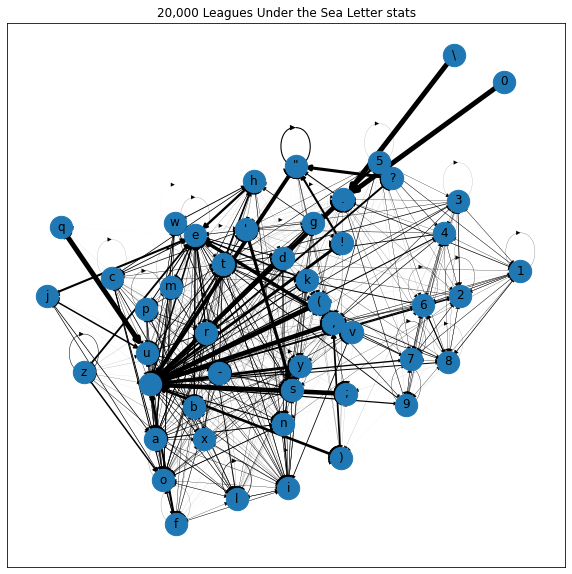

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Нарисуем граф связей
G = nx.DiGraph()

fig = plt.figure(figsize=(10, 10))

G.add_weighted_edges_from(edges)

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 500)
nx.draw_networkx_labels(G, pos)

for (node1, node2, edge_attr) in tqdm(G.edges(data=True)):
    nx.draw_networkx_edges(G, pos, edgelist=[(node1, node2)],width=edge_attr['weight'])

plt.title('20,000 Leagues Under the Sea Letter stats')
plt.show()